# Dipole
This example reproduces the topology constraint.

In [1]:

import os


In [2]:
from quadcoil import quadcoil

import desc
from desc.objectives import QuadcoilProxy,  ObjectiveFunction

from simsopt.util import MpiPartition, log
from simsopt.mhd import Vmec, Boozer, Quasisymmetry
from simsopt.objectives import LeastSquaresProblem
from simsopt.solve import least_squares_mpi_solve
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

import vmecpp
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0)]

## Loading files

In [28]:
# Loading equilibrium into VMEC
filename_pp = "wout_muse++.nc"
equil_pp = vmecpp.simsopt_compat.Vmec(filename_pp, keep_all_files=True)
surf_pp = equil_pp.boundary
net_poloidal_current_pp = equil_pp.external_current()

# Loading equilibrium into DESC
wout_file = "wout_muse++.nc"
desc_eq = desc.vmec.VMECIO.load(wout_file)
config.update('jax_enable_x64', False)

/mnt/c/Work/codes/DESC/desc/vmec.py:93: UserWarning: VMEC output appears to be from version 8.52 while DESC is only designed for compatibility with VMEC version 9. Some data may not be loaded correctly.
  warnings.warn(
/mnt/c/Work/codes/DESC/desc/utils.py:563: UserWarning: 
Not equal to tolerance rtol=3e-14, atol=3e-14
Incompatible constraints detected, cannot satisfy constraint <desc.objectives.linear_objectives.FixAxisR object at 0x7fe84cf49ba0>.
Mismatched elements: 1 / 7 (14.3%)
Max absolute difference: 9.094947e-13
Max relative difference: 6.418019e-08
 x: array([3.023549e-01, 3.263808e-02, 2.174698e-03, 1.476565e-04,
       1.417096e-05, 9.997507e-07, 5.438042e-08], dtype=float32)
 y: array([3.023549e-01, 3.263808e-02, 2.174698e-03, 1.476565e-04,
       1.417096e-05, 9.997507e-07, 5.438042e-08], dtype=float32)
 This may indicate incompatible constraints, or be due to floating point error.
  warnings.warn(colored(msg, "yellow"), err)
/mnt/c/Work/codes/DESC/desc/utils.py:563: User

AssertionError: 
Not equal to tolerance rtol=0.1, atol=1e-06
Incompatible constraints detected, cannot satisfy constraint <desc.objectives.linear_objectives.BoundaryRSelfConsistency object at 0x7fe84c1704c0>.
Mismatched elements: 5 / 98 (5.1%)
Max absolute difference: 7.74674118e-06
Max relative difference: inf
 x: array([ 0.000000e+00,  0.000000e+00, -4.855686e-13,  1.434455e-12,
        0.000000e+00, -7.100577e-13, -1.338033e-12,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00, -2.370325e-08,...
 y: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

In [4]:

dict = jnp.load('regcoil_muse++.npy', allow_pickle=True).item()
regcoili_qp = dict['regcoili_qp']
time_regcoil_list = dict['time_regcoil_list']
phi_ans_list = dict['phi_ans_list']
f_B_ans_list = dict['f_B_ans_list']
f_K_ans_list = dict['f_K_ans_list']
time_quadcoil_list = dict['time_quadcoil_list']
phi_test_list = dict['phi_test_list']
f_B_test_list = dict['f_B_test_list']
f_K_test_list = dict['f_K_test_list']

f_K at the inflection point: 21188205000.0
f_B at the inflection point: 7.074614e-09

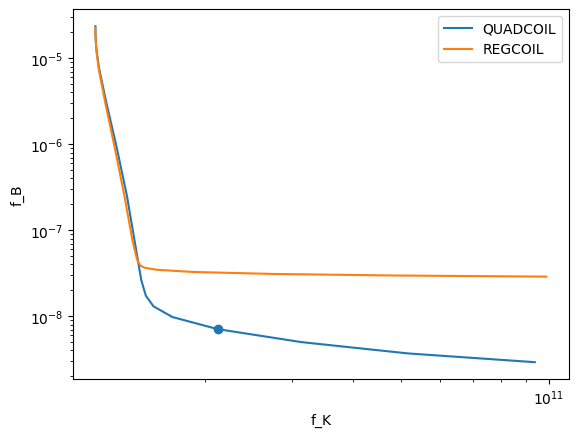

In [5]:
# inflection point
i_infl = np.argmin(f_K_test_list * f_B_test_list)
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('f_B')
plt.xlabel('f_K')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

# Problem settings

In [6]:
# Settings 
separation = 0.1
mpol = 12
ntor = 12
nfp = desc_eq.NFP
plasma_M_theta = 16
plasma_N_phi = 32

In [7]:
# We first create a dummy objective to extract its quadrature
# points. This will allow us to sanity check the objectie's value
# against baseline QUADCOIL.# Solving with the DESC interface
objective_dummy = QuadcoilProxy(
    eq=desc_eq,
    quadcoil_args={
        'plasma_coil_distance':0.1,
    },
    metric_name='f_max_Phi2',
    metric_target=0.,
    metric_weight=1.,
    plasma_M_theta=plasma_M_theta,
    plasma_N_phi=plasma_N_phi,
    # target=None,
    # bounds=None,
    # weight=1,
    normalize=False,
    normalize_target=False,
    name="QUADCOIL Proxy",
    verbose=True,
    # Bnormal_plasma_chunk_size=None,
    # source_grid=None,
    # jac_chunk_size=None,
)
objective_dummy.build()
plasma_quadpoints_phi = np.array(objective_dummy.plasma_quadpoints_phi)
plasma_quadpoints_theta = np.array(objective_dummy.plasma_quadpoints_theta)
winding_quadpoints_phi = np.linspace(0, 1, len(plasma_quadpoints_phi) * nfp)
winding_quadpoints_theta = np.linspace(0, 1, len(plasma_quadpoints_theta))


Precomputing transforms


In [8]:
net_poloidal_current_pp

209571.8859789997

In [9]:
print('max phi', jnp.max(phi_ans_list[i_infl]))
print('mean abs phi', jnp.average(jnp.abs(phi_ans_list[i_infl])))

max phi 4502.255
mean abs phi 139.15399


In [14]:
# Calculating normalization factors
from quadcoil.objective import f_max_Phi2, f_B, f_max_Phi, Phi
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')

quadcoil_kwargs = {
    'plasma_coil_distance':separation,
    'mpol':mpol,
    'ntor':ntor,
    'winding_quadpoints_phi': winding_quadpoints_phi,
    'winding_quadpoints_theta': winding_quadpoints_theta,
    'plasma_quadpoints_phi': plasma_quadpoints_phi,
    'plasma_quadpoints_theta': plasma_quadpoints_theta,
    'objective_name': 'f_max_Phi', # Minimizing peak dipole density
    'objective_unit': unit_Phi, # under an f_B constraint
    'constraint_name': ('f_B',),
    'constraint_type': ('<=',),
    'constraint_unit': (f_B_target,),
    'constraint_value': np.array([f_B_target,]),
    'fstop_outer': 1e-8, # convergence rate tolerance
    'xstop_outer': 0., # convergence rate tolerance
    'gtol_outer': 1e-8, # gradient tolerance
    'ctol_outer': 1e-8, # constraint tolerance
    'fstop_inner': 0.,
    'xstop_inner': 0.,
    'gtol_inner': 1e-8,
    'maxiter_tot': 10000,
    'maxiter_inner': 2000,
    'c_init': 1.,
}

Max(Phi^2) = 386066300.0 At the inflection point.
Max(Phi) = 19648.57 At the inflection point.


In [15]:
# Solving with the quadcoil default function
out_dict, qp, phi_mn, status = quadcoil(
    nfp=surf_pp.nfp,
    stellsym=surf_pp.stellsym,
    plasma_dofs=surf_pp.get_dofs(),
    plasma_mpol=surf_pp.mpol,
    plasma_ntor=surf_pp.ntor,
    net_poloidal_current_amperes=net_poloidal_current_pp,
    net_toroidal_current_amperes=0.,
    metric_name='f_max_Phi',
    verbose=False,
    **quadcoil_kwargs
)

In [16]:
status

{'inner_fin_c': Array(2.4729422e+08, dtype=float32, weak_type=True),
 'inner_fin_dl': Array(4.172325e-07, dtype=float32),
 'inner_fin_du': Array(7.309015e-08, dtype=float32),
 'inner_fin_dx_scaled': Array(0., dtype=float32),
 'inner_fin_f': Array(0.7663958, dtype=float32),
 'inner_fin_g': Array([0.], dtype=float32),
 'inner_fin_grad_f': Array(0.00063908, dtype=float32),
 'inner_fin_h': Array([0.], dtype=float32),
 'inner_fin_l': Array(0.7663958, dtype=float32),
 'inner_fin_lam': Array([0.], dtype=float32),
 'inner_fin_mu': Array([97.89438], dtype=float32),
 'inner_fin_niter': Array(4, dtype=int32),
 'inner_fin_x': Array([-3.09468164e+03, -3.77790497e+02,  1.69624924e+02,  4.94382248e+01,
        -2.30909157e+01,  3.12774353e+01, -3.61922989e+01, -1.27804680e+01,
         8.80198059e+01,  2.36784668e+02,  2.83745575e+02,  7.01719727e+02,
        -3.09829926e+02, -1.67857590e+02,  1.52429361e+01,  1.28217554e+00,
        -9.81581783e+00, -4.49811935e+00,  2.18448505e+01, -1.35189152e+01,

f_B from REGCOIL:       7.1017476e-09
f_B from QUADCOIL:      7.074614e-09
Max dipole dens from REGCOIL:       19648.57
Max dipole dens from QUADCOIL:      15058.582 23.36 % improvement


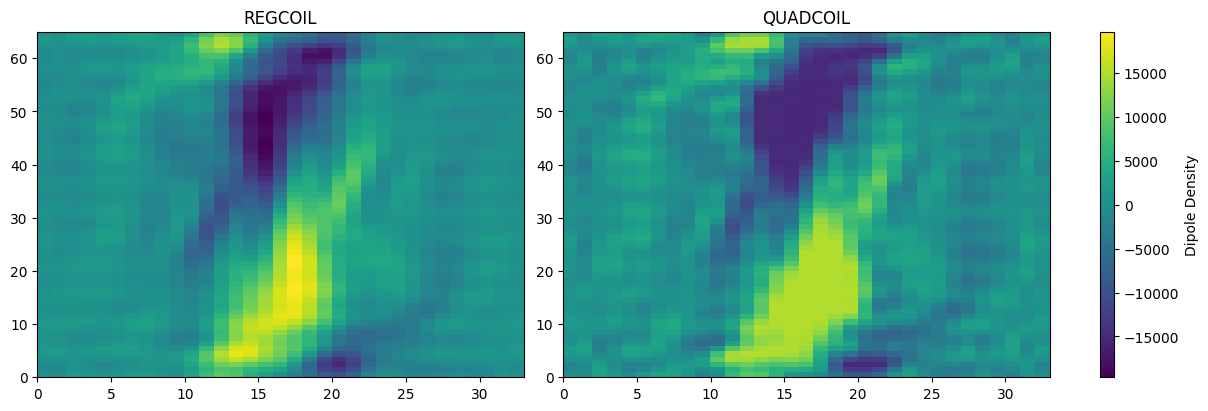

In [17]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL:     ', f_B(qp, phi_mn))
# print('f_B from QUADCOIL+DESC:', f_B(qp_obj, phi_mn_obj))
f_Phi_crtl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
f_Phi_1 = f_max_Phi(qp, phi_mn)
# f_Phi_2 = f_max_Phi(qp_obj, phi_mn_obj)
print('Max dipole dens from REGCOIL:      ', f_Phi_crtl)
print('Max dipole dens from QUADCOIL:     ', f_Phi_1, round((f_Phi_crtl-f_Phi_1)/f_Phi_crtl*100, 3), '% improvement')
# print('Max dipole dens from QUADCOIL+DESC:', f_Phi_2, round((f_Phi_crtl-f_Phi_2)/f_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(qp, phi_test_list[i_infl])
phi_quadcoil = Phi(qp, phi_mn)
# phi_quadcoil2 = Phi(qp, phi_mn_obj)
cmin = np.min([phi_regcoil, phi_quadcoil])
cmax = np.max([phi_regcoil, phi_quadcoil])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
# fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].pcolor(phi_regcoil, vmin=cmin, vmax=cmax)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].pcolor(phi_quadcoil, vmin=cmin, vmax=cmax)
axes[1].set_title('QUADCOIL')

# Plot for QUADCOIL
# im1 = axes[2].pcolor(-phi_quadcoil2, vmin=cmin, vmax=cmax)
# axes[2].set_title('QUADCOIL_DESC')


# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density")

plt.show()


# Quasi-single-stage
Caoxiang's objective is:
```
prob = LeastSquaresProblem.from_tuples([(equil.volume, 0.012, 1e6),
                                        (equil.iota_axis, 0.18, 1e4),
                                        (equil.iota_edge, 0.2, 1e4),
                                        (qs.J, 0, 1e7),
                                        (reg.J, 0, 1)])
```
It's easier to do 2-term QS in DESC so we swap out that.

In [18]:
A = surf_pp.aspect_ratio()

In [19]:
from desc.grid import LinearGrid
from desc.objectives import ObjectiveFunction, ForceBalance, QuasisymmetryTwoTerm, RotationalTransform, QuadcoilProxy, Volume, AspectRatio
from desc.optimize import Optimizer

In [20]:
print('Eq resolution', desc_eq.M_grid, desc_eq.N_grid, desc_eq.L_grid)

Eq resolution 14 12 14


In [21]:
quadcoil_objective = QuadcoilProxy(
    eq=desc_eq,
    quadcoil_args=quadcoil_kwargs,
    metric_name=('f_max_Phi',),
    metric_target=np.array([0.,]),
    metric_weight=np.array([1./unit_Phi,]),
    plasma_M_theta=plasma_M_theta,
    plasma_N_phi=plasma_N_phi,
    normalize=False,
    normalize_target=False,
    name="QUADCOIL Proxy",
)
quadcoil_objective.build()

/mnt/c/Work/codes/DESC/desc/objectives/_quadcoil.py:167: UserWarning: Redundant arguments detected: {'plasma_quadpoints_theta', 'plasma_quadpoints_phi'}. These arguments are extracted from the equilibrium, or specified by other parameters. The provided values will be discarded.
  warnings.warn(


Precomputing transforms


In [22]:
import time
import jax

In [23]:
# Timing quadcoil
time1 = time.time()
test_f = quadcoil_objective.compute_unscaled(*quadcoil_objective.xs(desc_eq))
print('objective', jax.block_until_ready(test_f))
time2 = time.time()
print('time:', time2-time1)

objective [11597.685]
time: 25.849499464035034


In [24]:
time1 = time.time()
test_f = quadcoil_objective.compute_unscaled(*quadcoil_objective.xs(desc_eq))
print('objective', jax.block_until_ready(test_f))
time2 = time.time()
print('time:', time2-time1)

objective [11597.685]
time: 17.481800317764282


In [25]:
# Building grids
qsgrid = LinearGrid(
    M=desc_eq.M_grid, N=desc_eq.N_grid, NFP=desc_eq.NFP, rho=np.array([0.1, 1.0]), sym=True
)

iotagridaxis = LinearGrid(
    M=desc_eq.M_grid, N=desc_eq.N_grid, NFP=desc_eq.NFP, rho=np.array([0.01]), sym=True
)

iotagridedge = LinearGrid(
    M=desc_eq.M_grid, N=desc_eq.N_grid, NFP=desc_eq.NFP, rho=np.array([1.0]), sym=True
)

constraints = (
    ForceBalance(eq=desc_eq),
)

objective = ObjectiveFunction((
    Volume(eq=desc_eq, target=0.012),
    AspectRatio(
        eq=desc_eq,
        target=A,
        weight=1,
    ),
    QuasisymmetryTwoTerm(
        eq=desc_eq,
        helicity=(1, 0), # QA
        grid=qsgrid,
    ),
    # Axis rotational transform
    RotationalTransform(
        eq=desc_eq,
        target=0.18,
        weight=1,
        grid=iotagridaxis,
    ),
    # Edge rotational transform
    RotationalTransform(
        eq=desc_eq,
        target=0.2,
        weight=1,
        grid=iotagridedge,
    ),
    quadcoil_objective
))


In [ ]:
optimizer = Optimizer("lsq-auglag")
if not os.path.exists('error_eq.h5'):
    eqa, history = desc_eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        # each iteration of the augmented Lagrangian optimizer is cheaper than a step of a
        # proximal optimizer, but it generally requires more iterations to converge
        maxiter=1, # For now fails at iter #2
        copy=True,
        verbose=3,
        options={},
    )
    eqa.save('error_eq.h5')
else:
    eqa = desc.io.load("error_eq.h5")

In [27]:
optimizer = Optimizer("lsq-auglag")
if not os.path.exists('test_eq.h5'):
    eqb, history = desc_eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        # each iteration of the augmented Lagrangian optimizer is cheaper than a step of a
        # proximal optimizer, but it generally requires more iterations to converge
        maxiter=100, # For now fails at iter #2
        copy=True,
        verbose=3,
        options={},
    )
    eqb.save('test_eq.h5')
else:
    eqb = desc.io.load("test_eq.h5")

Building objective: volume
Precomputing transforms
Timer: Precomputing transforms = 883 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 55.8 ms
Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 630 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 602 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 32.4 ms
Timer: Objective build = 3.21 sec
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 366 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 761 ms
Timer: Objective build = 855 ms
Timer: LinearConstraintProjection build = 7.48 sec
Timer: LinearConstraintProjection build = 151 ms
Number of paramet

In [ ]:
import desc

In [ ]:
desc.plotting.plot_surfaces(eqa)

In [ ]:
time1 = time.time()
test_f = quadcoil_objective.compute_unscaled(*quadcoil_objective.xs(eqa))
print('objective', jax.block_until_ready(test_f))
time2 = time.time()
print('time:', time2-time1)